In [1]:
import copy
from pathlib import Path
import warnings

import numpy as np
import pandas as pd
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
import torch

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

In [2]:
model_paths = ["Save_File/All_building_seperate_05_31/1/checkpoints/1.ckpt",
                "Save_File/All_building_seperate_05_31/2/checkpoints/2.ckpt",
                "Save_File/All_building_seperate_05_31/3/checkpoints/3.ckpt",
                "Save_File/All_building_seperate_05_31/4/checkpoints/4.ckpt",
                "Save_File/All_building_seperate_05_31/5/checkpoints/5.ckpt"]

data_paths = ["Refined_Data/Seperated_Data/1.csv",
                "Refined_Data/Seperated_Data/2.csv",
                "Refined_Data/Seperated_Data/3.csv",
                "Refined_Data/Seperated_Data/4.csv",
                "Refined_Data/Seperated_Data/5.csv"]

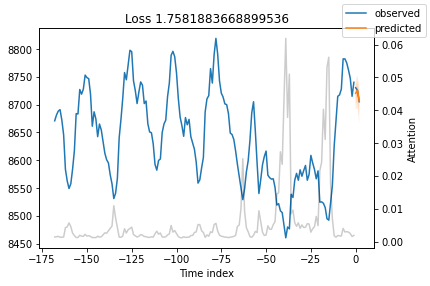

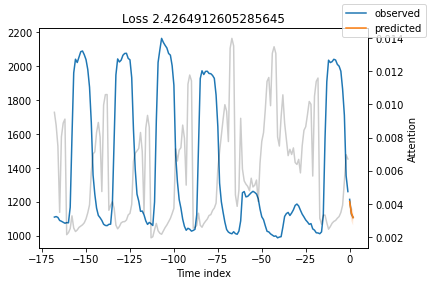

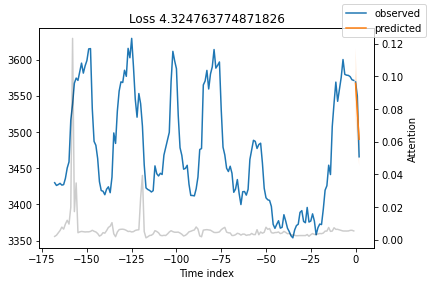

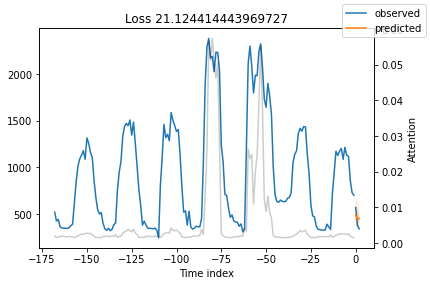

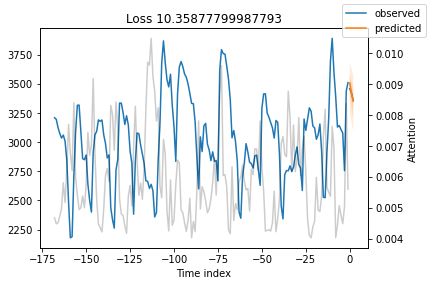

In [3]:
for i in range(len(model_paths)):
    model_path = model_paths[i]

    data = pd.read_csv(data_paths[i], index_col=0)
    data['num'] = data['num'].apply(str)
    data['Week'] = data['Week'].apply(str)
    data['24Hour'] = data['24Hour'].apply(str)

    max_prediction_length = 3
    max_encoder_length = 168
    training_cutoff = data["time_idx"].max() - max_prediction_length

    training = TimeSeriesDataSet(
        data[lambda x: x.time_idx <= training_cutoff],
        time_idx="time_idx",
        target="kWH",
        group_ids=["num"],
        min_encoder_length=max_encoder_length//2,
        max_encoder_length=max_encoder_length,
        min_prediction_length=3,
        max_prediction_length=max_prediction_length,
        static_categoricals=["num"],
        static_reals=["non_electric_aircondition", "sunlight"],
        time_varying_known_categoricals=["Week", "24Hour"],
        time_varying_known_reals=["C", "m/s", "wet", "mm", "hr", "time_idx"],
        time_varying_unknown_categoricals=[],
        time_varying_unknown_reals=["kWH"],
        add_relative_time_idx=True,
        add_target_scales=True,
        add_encoder_length=True,
    )

    # create validation set (predict=True) which means to predict the last max_prediction_length points in time
    # for each series
    validation = TimeSeriesDataSet.from_dataset(training, data, predict=True, stop_randomization=True)

    # create dataloaders for model
    batch_size = 32  # set this between 32 to 128
    train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
    val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)

    best_tft = TemporalFusionTransformer.load_from_checkpoint(model_path)

    raw_predictions, x = best_tft.predict(val_dataloader, mode="raw", return_x=True)

    best_tft.plot_prediction(x, raw_predictions, idx=0, add_loss_to_title=True)